# 유피아 BuySide 코드 리뷰

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!pip install quantstats
!pip install PyPortfolioOpt
!pip install riskfolio-lib
!pip install yfinance
!pip install FinQuant

## 런타임 재시작

---

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.float_format', '{:.6f}'.format)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

import datetime
import yfinance as yf
import numpy as np
import warnings

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier, objective_functions, risk_models
from pypfopt.plotting import plot_efficient_frontier
from pypfopt import plotting


import riskfolio as rp

# 0. 자산군 불러오기

In [ ]:
ticker_labels = {
    'ticker': ['^KS200', '^GSPC', '^STOXX50E', '^N225','HYG', 'GC=F', 'CL=F', '^DJI', '^IXIC', '^VIX', '^HSI', '000001.SS', 'KC=F', 'ZN=F'],
    'labels': ['코스피', 'S&P500', '유로스탁스', '닛케이', '하이일드', 'GOLD', 'WTI', '다우', '나스닥', 'VIX', '항셍', '상하이', '커피', '10년물']
}

new_dict = dict(zip(ticker_labels["ticker"], ticker_labels["labels"]))

# Date range
start = '2012-10-04'
end = '2022-10-04'

asset = yf.download(ticker_labels['ticker'], start = start, end = end)
asset = asset.loc[:,('Adj Close', slice(None))]
asset = asset.rename(columns=new_dict)
asset.columns = asset.columns.droplevel(level=0)
asset = asset.sort_index(axis=1)
asset = asset.dropna()
asset

[*********************100%%**********************]  14 of 14 completed


,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
Date,,,,,,,,,,,,,,
2012-10-09,133.046875,1763.000000,1441.479980,16.370001,92.389999,3065.020020,8769.589844,13473.530273,2115.229004,2472.229980,165.300003,259.660004,51.745823,20937.279297
2012-10-10,133.218750,1763.199951,1432.560059,16.290001,91.250000,3051.780029,8596.230469,13344.969727,2119.941895,2456.540039,163.449997,255.149994,51.622177,20919.599609
2012-10-11,133.265625,1768.800049,1432.839966,15.590000,92.070000,3049.409912,8546.780273,13326.389648,2102.867920,2487.080078,160.750000,252.839996,51.903175,20999.050781
2012-10-12,133.312500,1758.000000,1428.589966,16.139999,91.860001,3044.110107,8534.120117,13328.849609,2104.931885,2469.090088,161.699997,252.440002,51.993099,21136.429688
2012-10-15,133.312500,1736.000000,1440.130005,15.270000,91.849998,3064.179932,8577.929688,13424.230469,2098.702881,2485.120117,160.850006,251.440002,52.229187,21148.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,111.359375,1623.300049,3655.040039,32.259998,76.709999,10802.919922,26431.550781,29260.810547,3051.229980,3342.560059,223.800003,289.769989,66.941124,17855.140625
2022-09-27,110.890625,1626.699951,3647.290039,32.599998,78.500000,10829.500000,26571.869141,29134.990234,3093.860107,3328.649902,224.350006,290.200012,66.800270,17860.310547
2022-09-28,112.859375,1660.400024,3719.040039,30.180000,82.150002,11051.639648,26173.980469,29683.740234,3045.070068,3335.300049,228.699997,283.190002,67.992958,17250.880859


# 1.PyPortfolio로 최적화

In [ ]:
# Calculate expected returns and sample covariance
df = asset
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

ef.portfolio_performance(verbose=True)

Expected annual return: 15.1%
Annual volatility: 12.3%
Sharpe Ratio: 1.06


(0.15068207881528117, 0.12285430311427968, 1.0637159261220184)

In [ ]:
cleaned_weights

OrderedDict([('10년물', 0.0),
             ('GOLD', 0.0),
             ('S&P500', 0.0),
             ('VIX', 0.07884),
             ('WTI', 0.0),
             ('나스닥', 0.68792),
             ('닛케이', 0.22898),
             ('다우', 0.0),
             ('상하이', 0.0),
             ('유로스탁스', 0.0),
             ('커피', 0.00427),
             ('코스피', 0.0),
             ('하이일드', 0.0),
             ('항셍', 0.0)])

## 실제로 어떤 비중으로 매수해야할까?

In [ ]:
latest_prices = get_latest_prices(df)


da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'나스닥': 65, '닛케이': 8, 'VIX': 2493, '커피': 19}
Funds remaining: $22048.89


# 2. FinQuant로 시각화

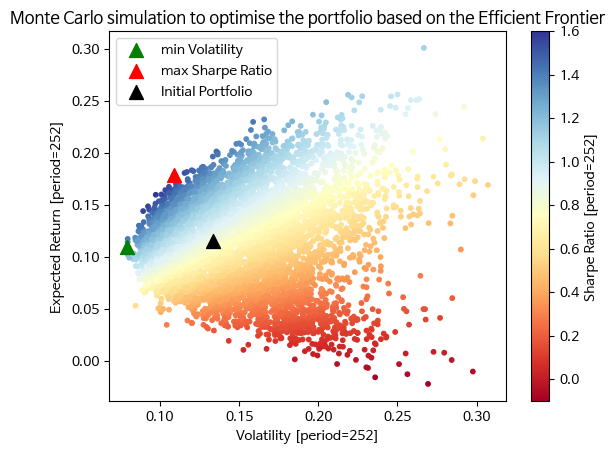

In [ ]:
from finquant.portfolio import build_portfolio
pf = build_portfolio(data=df)
opt_w, opt_res = pf.mc_optimisation(num_trials=5000)
pf.mc_plot_results()

# 3. Riskfolio-Lib 모델링

In [58]:
# Calculating returns
Y = asset.pct_change().dropna()

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

## 자산 비중 시각화

In [59]:
MV_W = w.T

In [60]:
MV_W

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
weights,0.000001,0.000002,0.131545,0.101483,0.000000,0.565235,0.157936,0.000004,0.000001,0.000000,0.043793,0.000000,0.000000,0.000000


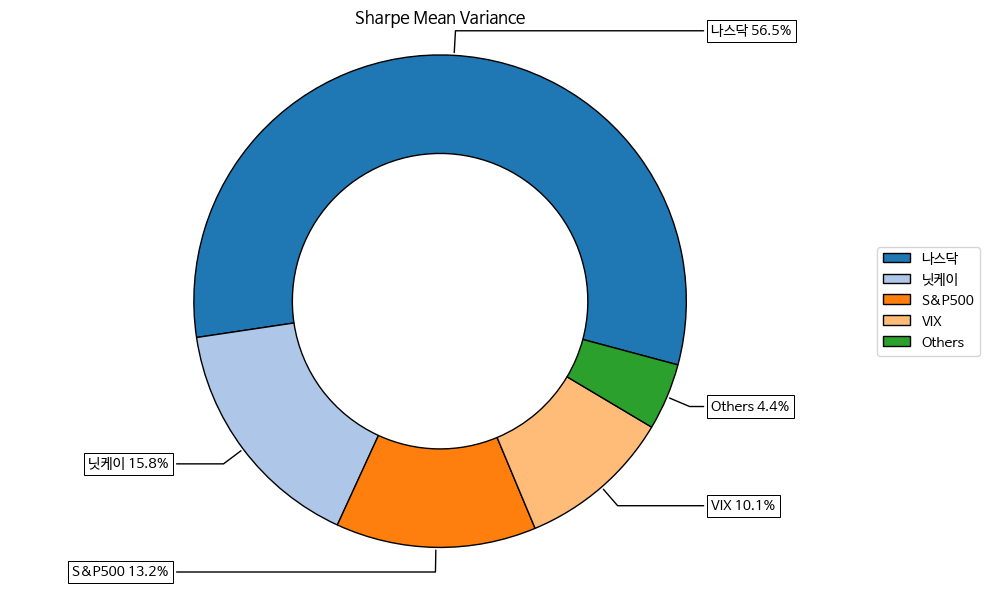

In [ ]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25,
                 cmap = "tab20", height=6, width=10, ax=None)

## 효율적 투자곡선 시각화

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
0,0.678803,0.000000,0.000000,0.009678,0.000026,0.000000,0.024130,0.057898,0.023032,0.036491,0.008478,0.008950,0.149441,0.003073
1,0.482023,0.000000,0.173402,0.040074,0.000000,0.131691,0.074822,0.000000,0.017692,0.017436,0.021334,0.000000,0.041527,0.000000
2,0.371465,0.000000,0.195899,0.055901,0.000000,0.231149,0.099314,0.000000,0.013085,0.005121,0.028066,0.000000,0.000000,0.000000
3,0.247932,0.004202,0.189678,0.070022,0.000000,0.326492,0.119796,0.000000,0.008201,0.000000,0.033677,0.000000,0.000000,0.000000
4,0.129406,0.009473,0.179559,0.083425,0.000000,0.417876,0.138084,0.000000,0.003332,0.000000,0.038845,0.000000,0.000000,0.000000


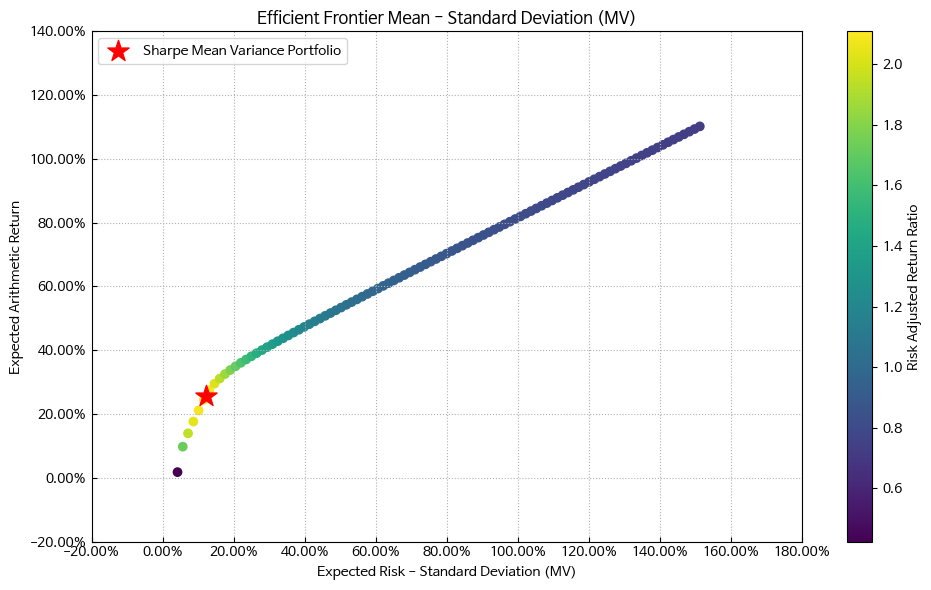

In [ ]:
points = 100 # Number of points of the frontier
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
display(frontier.T.head())

mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets
rf = 0

label = 'Sharpe Mean Variance Portfolio' # Title of point


ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=Y, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

## 투자 비중에 따른 자산 비중 변화율

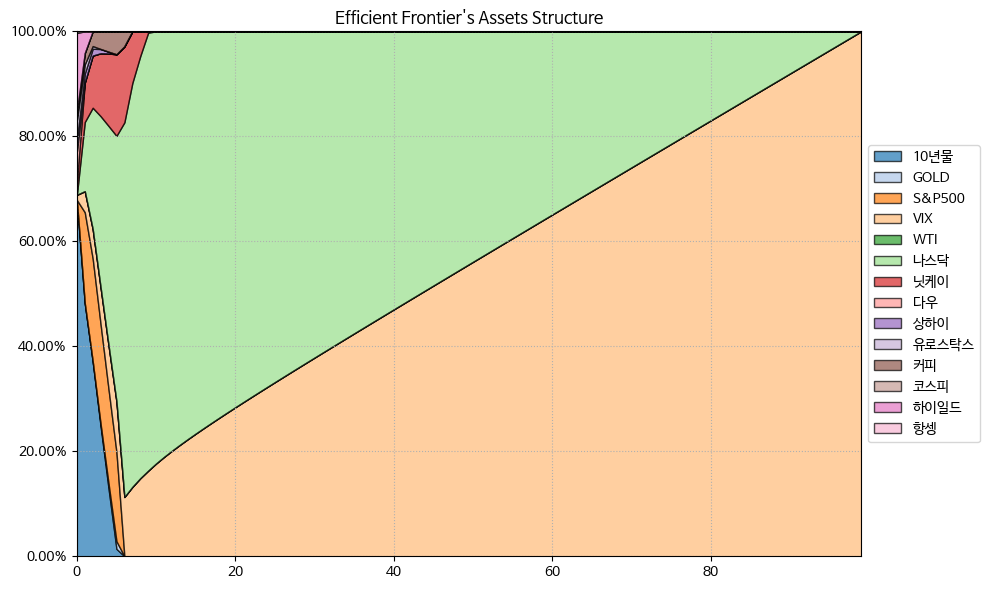

In [ ]:
# Plotting efficient frontier composition
ax = rp.plot_frontier_area(w_frontier=frontier, cmap="tab20", height=6, width=10, ax=None)

## 리스크 지표에 따른 투자 비중 변화량

In [ ]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
10년물,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
GOLD,0.00%,0.00%,0.46%,0.00%,0.60%,6.18%,7.91%,16.88%,0.00%,5.40%,0.00%,3.46%,0.66%
S&P500,13.15%,56.91%,22.78%,53.60%,19.60%,19.45%,0.00%,0.00%,0.00%,51.32%,0.00%,40.26%,0.00%
VIX,10.15%,9.69%,11.92%,9.92%,12.10%,11.78%,12.28%,11.59%,15.73%,9.38%,14.36%,11.43%,14.77%
WTI,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,1.79%,0.00%,0.97%,0.00%,1.23%
나스닥,56.52%,23.18%,49.11%,24.77%,51.45%,46.79%,53.18%,28.46%,43.87%,9.36%,26.73%,8.63%,36.47%
닛케이,15.79%,7.33%,11.18%,7.21%,11.54%,10.27%,16.37%,10.70%,19.33%,4.77%,12.77%,6.15%,18.87%
다우,0.00%,0.00%,0.00%,1.62%,0.00%,0.00%,0.00%,19.00%,17.47%,19.77%,41.06%,28.51%,22.41%
상하이,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
유로스탁스,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


## 리스크 지표에 따른 투자 비중 변화량 차트

<Axes: >

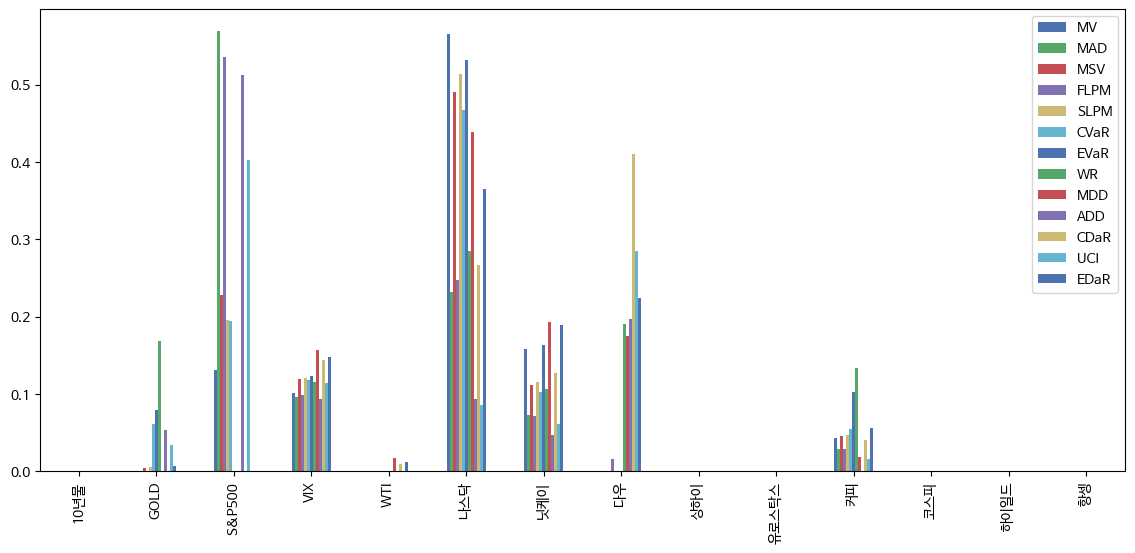

In [ ]:
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

------
# 리스크 패리티, 블랙 리터만, 제약 조건 (nonconvex)

In [ ]:
# Calculate expected returns and sample covariance
df = asset
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

ef.portfolio_performance(verbose=True)

Expected annual return: 42.3%
Annual volatility: 28.7%
Sharpe Ratio: 1.40


(0.42264157254238544, 0.28697906981816673, 1.4030346282657609)

In [ ]:
cleaned_weights

OrderedDict([('10년물', -0.85486),
             ('GOLD', 0.11259),
             ('S&P500', 1.0),
             ('VIX', 0.15437),
             ('WTI', -0.01681),
             ('나스닥', 1.0),
             ('닛케이', 0.93734),
             ('다우', -0.48067),
             ('상하이', 0.28672),
             ('유로스탁스', -0.16147),
             ('커피', 0.06097),
             ('코스피', -0.34738),
             ('하이일드', 0.1012),
             ('항셍', -0.79198)])

In [ ]:
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'S&P500': 76, '나스닥': 26, '닛케이': 10, '상하이': 25, 'VIX': 1336, 'GOLD': 18, '하이일드': 413, '커피': 76, '10년물': -7628, '항셍': -45, '다우': -17, '코스피': -1234, '유로스탁스': -49, 'WTI': -211}
Funds remaining: $9284.03


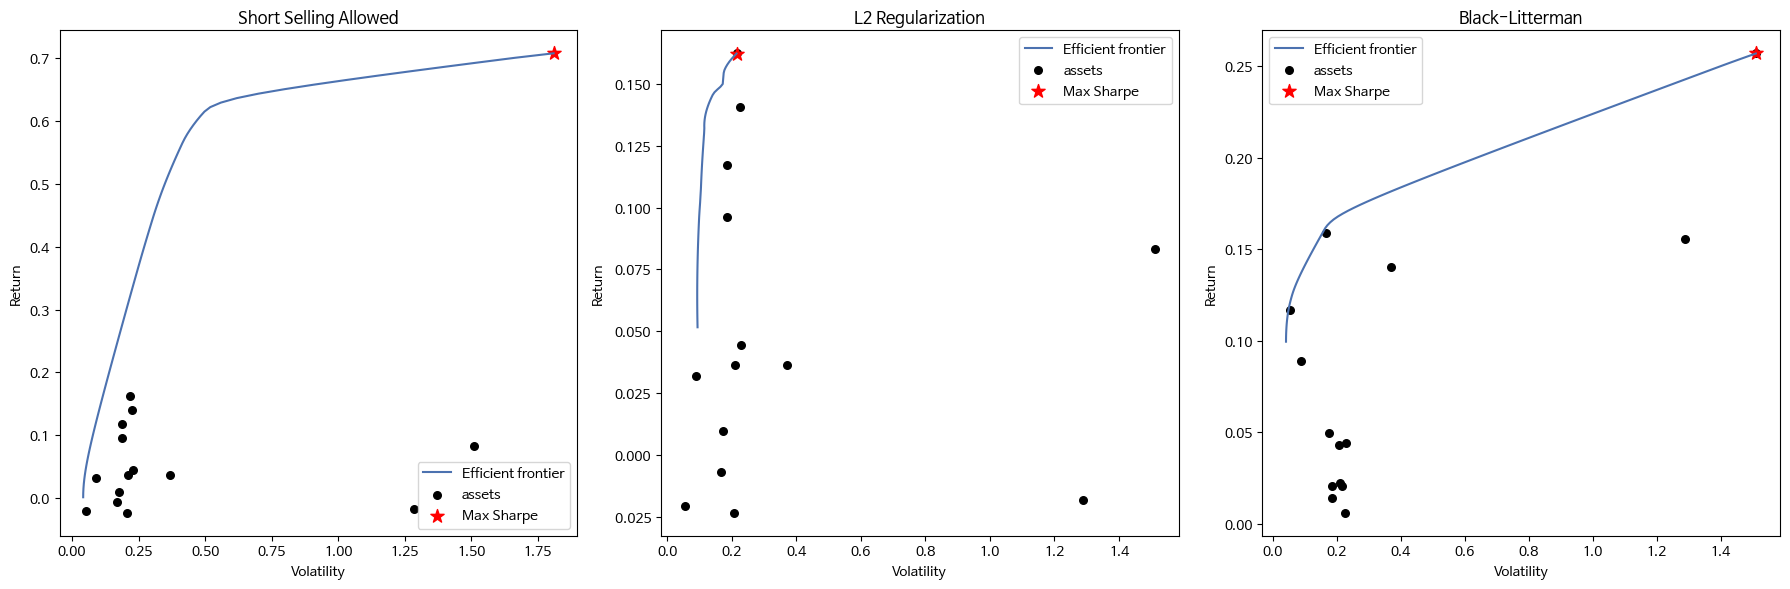

In [ ]:
ef0, ef1, ef2 = -1, -1, -1

# 공매도
ef0 = EfficientFrontier(mu, S, weight_bounds=(-1, 1))

# 정규화 (균등 투자에 가중치)
ef1 = EfficientFrontier(mu, S)
ef1.add_objective(objective_functions.L2_reg, gamma=1)

# 블랙 리터만
S = risk_models.sample_cov(df)
viewdict = {
    '코스피': 0.05,
    'S&P500': -0.05,
    '유로스탁스': 0.03,
    '닛케이': -0.03,
    '하이일드': 0.15,
    'GOLD': 0.20,
    'WTI': 0.25,
    '다우': -0.04,
    '나스닥': -0.02,
    'VIX': -0.10,
    '항셍': 0.05,
    '상하이': 0.04,
    '커피': 0.20,
    '10년물': 0.15
}

from pypfopt.black_litterman import BlackLittermanModel
bl = BlackLittermanModel(S, pi="equal", absolute_views=viewdict, omega="default")
rets = bl.bl_returns()
ef2 = EfficientFrontier(rets, S)
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18,6))  # 1 row, 3 columns subplot 생성

# ef0 (공매도)
plot_efficient_frontier(ef0, ax=axs[0], color='red')
axs[0].set_title('Short Selling Allowed')

# ef1 (정규화)
plot_efficient_frontier(ef1, ax=axs[1], color='blue')
axs[1].set_title('L2 Regularization')

# ef2 (블랙 리터만)
plot_efficient_frontier(ef2, ax=axs[2], color='green')
axs[2].set_title('Black-Litterman')

# 각 그래프에 탄젠시 포트폴리오 (최대 샤프 비율) 추가 (선택사항)
for ax, ef in zip(axs, [ef0, ef1, ef2]):
    ret_tangent, std_tangent, _ = ef.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")
    ax.legend()

plt.tight_layout()
plt.show()

# 2. finQuant로 시각화

In [ ]:
pf = build_portfolio(data=asset)
print(pf)
pf.properties()

# # Portfolio optimisation
# ## Efficient Frontier
# Based on the **Efficient Frontier**, the portfolio can be optimised for
#  - minimum volatility
#  - maximum Sharpe ratio
#  - minimum volatility for a given target return
#  - maximum Sharpe ratio for a given target volatility
# See below for an example for each optimisation.

# if needed, change risk free rate and frequency/time window of the portfolio
print("pf.risk_free_rate = {}".format(pf.risk_free_rate))
print("pf.freq = {}".format(pf.freq))

Contains information about a portfolio.
----------------------------------------------------------------------
Stocks: 10년물, GOLD, S&P500, VIX, WTI, 나스닥, 닛케이, 다우, 상하이, 유로스탁스, 커피, 코스피, 하이일드, 항셍
Time window/frequency: 252
Risk free rate: 0.005
Portfolio Expected Return: 0.116
Portfolio Volatility: 0.134
Portfolio Downside Risk: 0.141
Portfolio Value at Risk: 0.336
Confidence level of Value at Risk: 95.00 %
Portfolio Sharpe Ratio: 0.828
Portfolio Sortino Ratio: 0.783

Skewness:
      10년물     GOLD   S&P500      VIX      WTI      나스닥      닛케이       다우  \
0 0.176493 0.646122 0.727338 2.925762 0.417340 0.843138 0.036558 0.414969   

       상하이    유로스탁스       커피      코스피     하이일드       항셍  
0 0.079467 0.174919 1.128407 1.263385 0.247625 0.238112  

Kurtosis:
       10년물      GOLD    S&P500       VIX       WTI       나스닥       닛케이  \
0 -0.214731 -1.043819 -0.477537 14.889608 -0.657702 -0.444643 -0.515492   

         다우      상하이     유로스탁스       커피      코스피      하이일드        항셍  
0 -0.995870 0.61

In [ ]:
pf.ef_efficient_return(0.22, verbose=True)

----------------------------------------------------------------------
Optimised portfolio for Efficient Return

Time window/frequency: 252
Risk free rate: 0.005
Expected annual Return: 0.220
Annual Volatility: 0.105
Sharpe Ratio: 2.045

Optimal weights:
               10년물     GOLD   S&P500      VIX      WTI      나스닥      닛케이  \
Allocation 0.099053 0.011286 0.174159 0.086790 0.000000 0.443439 0.141883   

                 다우      상하이    유로스탁스       커피      코스피     하이일드       항셍  
Allocation 0.000000 0.003276 0.000000 0.040114 0.000000 0.000000 0.000000  
----------------------------------------------------------------------


,Allocation
10년물,0.099053
GOLD,0.011286
S&P500,0.174159
VIX,0.086790
WTI,0.000000
나스닥,0.443439
닛케이,0.141883
다우,0.000000
상하이,0.003276
유로스탁스,0.000000


        Allocation
10년물      0.678920
GOLD      0.000000
S&P500    0.000000
VIX       0.009667
WTI       0.000000
나스닥       0.000000
닛케이       0.024031
다우        0.057000
상하이       0.023318
유로스탁스     0.037154
커피        0.008525
코스피       0.010028
하이일드      0.149280
항셍        0.002077


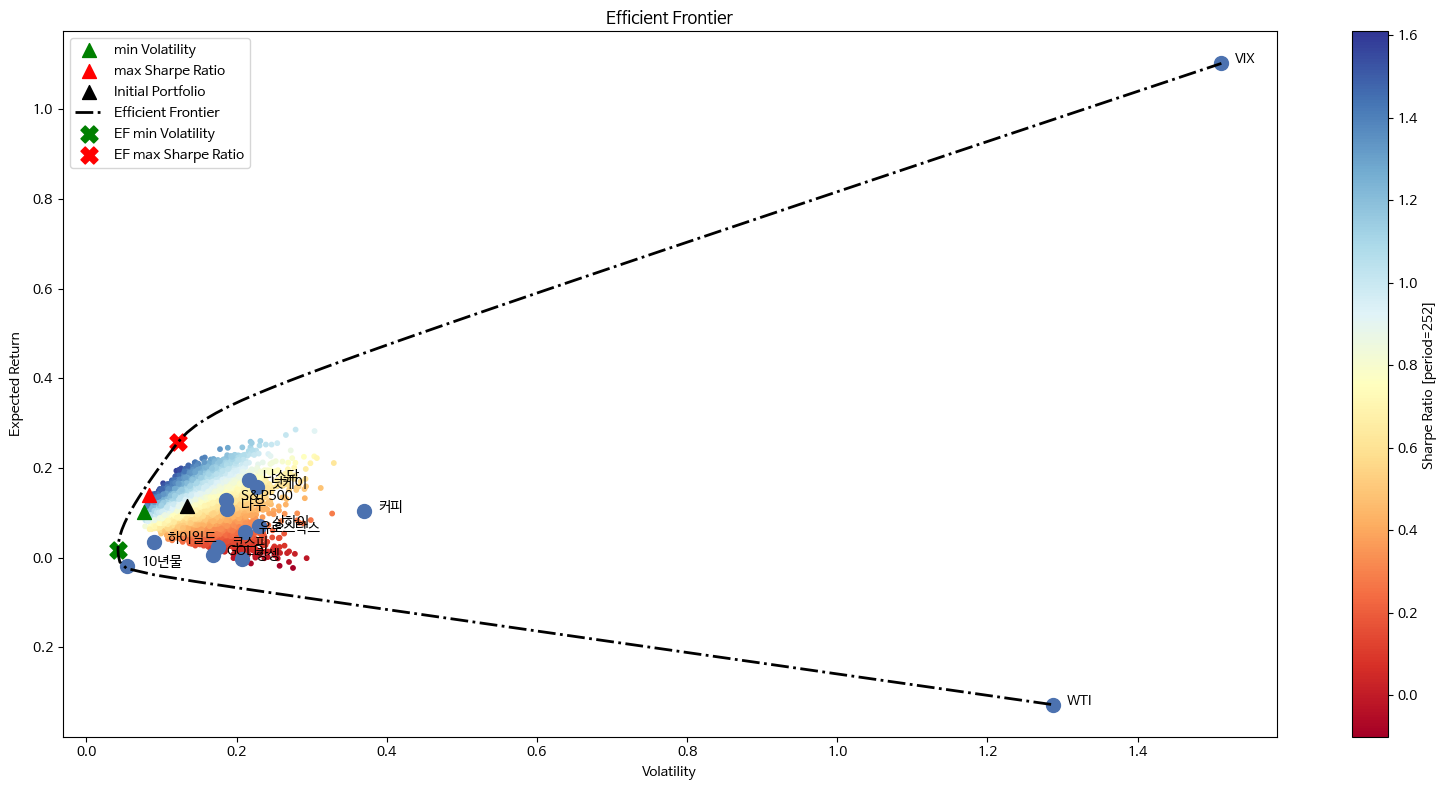

In [ ]:
from finquant.efficient_frontier import EfficientFrontier
ef = EfficientFrontier(pf.comp_mean_returns(freq=1), pf.comp_cov())

# optimisation for minimum volatility
print(ef.minimum_volatility())

opt_w, opt_res = pf.mc_optimisation(num_trials=5000)
plt.figure(figsize=(16,8))
pf.mc_plot_results()
pf.ef_plot_efrontier()
pf.ef.plot_optimal_portfolios()
pf.plot_stocks()

plt.tight_layout()
plt.show()

# 3. Liskfolio-Lib으로 모델링

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
weights,0.343946,0.072118,0.060474,0.030180,0.010767,0.056374,0.044584,0.060121,0.044956,0.052834,0.036690,0.047799,0.099231,0.039925


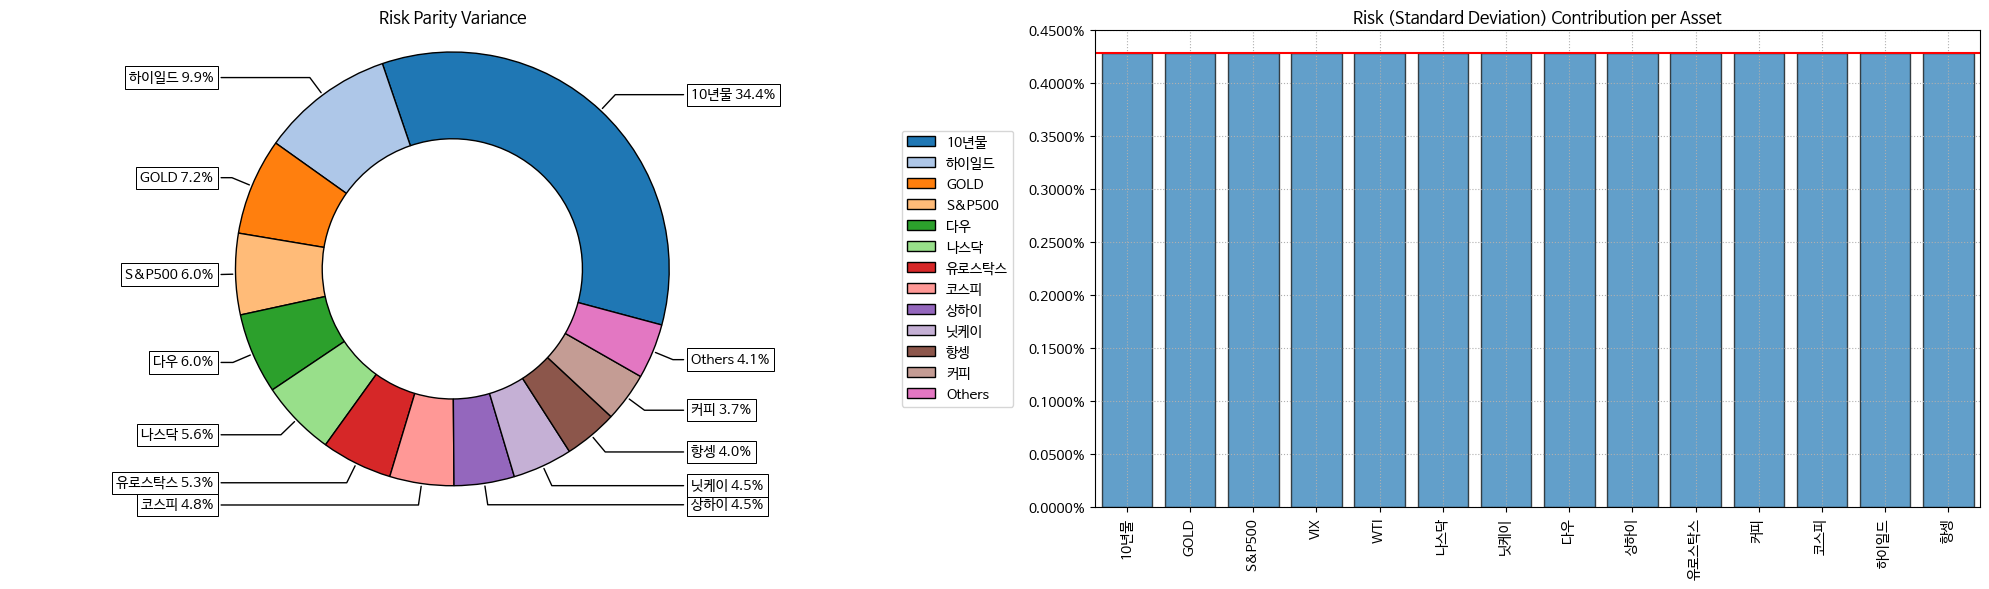

In [ ]:
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = 'Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

# Plotting the composition of the portfolio

# Plotting the composition of the portfolio and risk composition side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the composition of the portfolio
rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[0])

# Plotting the risk composition of the portfolio
rp.plot_risk_con(w_rp, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01, color="tab:blue", erc_line=True, height=6, width=10, ax=axs[1])

# Show plots
plt.tight_layout()
plt.show()

A : without regularization and penalization constraints.

B : with regularization constraint but without penalization constraint.

C : with regularization and penalization constraints.

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
weights,0.204973,0.087853,0.073423,0.038010,0.013049,0.070397,0.055942,0.072629,0.057185,0.064775,0.047779,0.060927,0.101250,0.051807


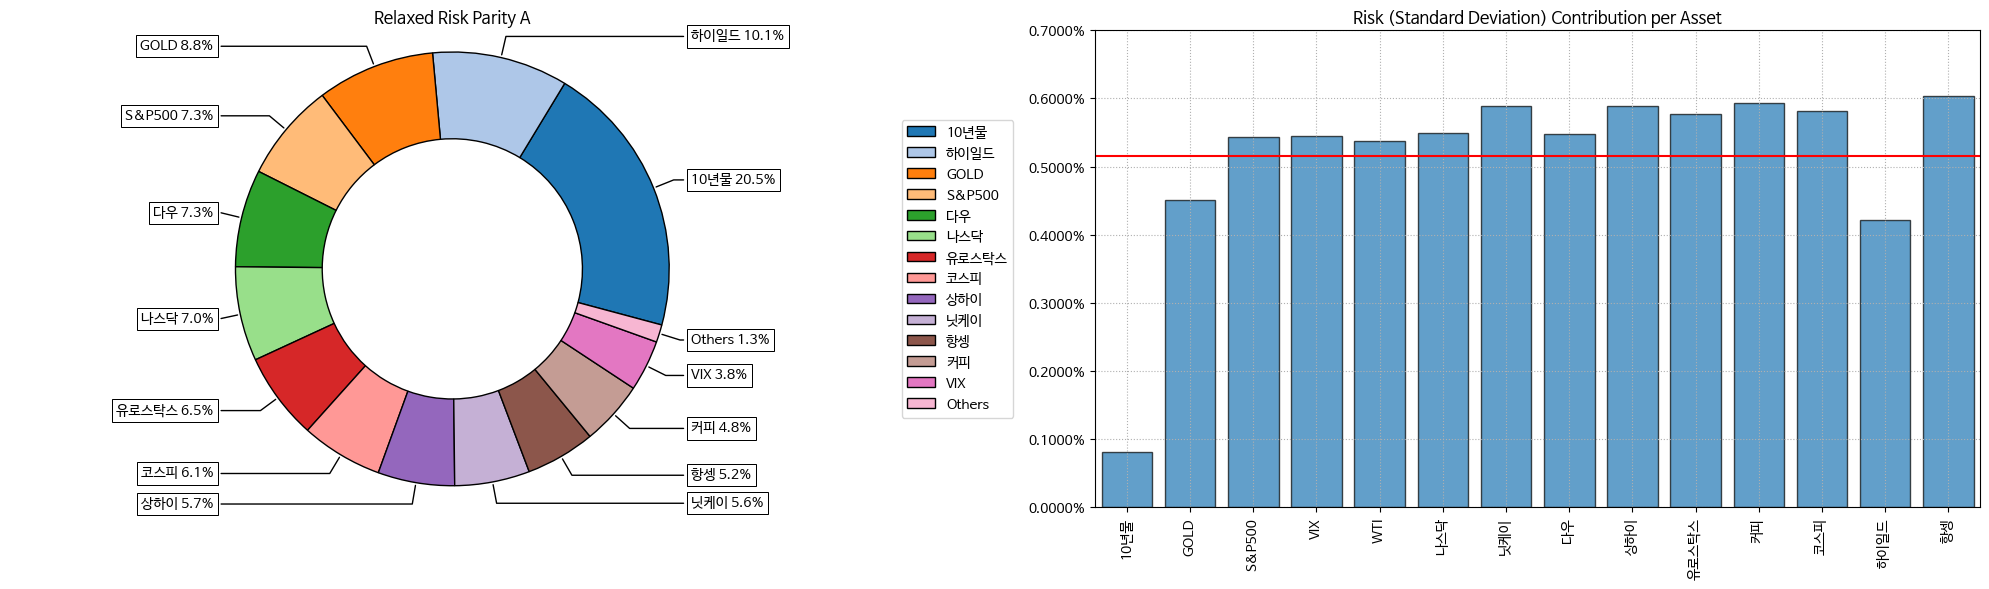

In [ ]:
b = None # Risk contribution constraints vector
version = 'A' # Could be A, B or C
l = 1 # Penalty term, only valid for C version

# Setting the return constraint
port.lowerret = 0.00025

w_rrp_a = port.rrp_optimization(model=model, version=version, l=l, b=b, hist=hist)

display(w_rrp_a.T)

# Plotting the composition of the portfolio and risk composition side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the composition of the portfolio
rp.plot_pie(w=w_rrp_a, title='Relaxed Risk Parity A', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[0])

# Plotting the risk composition of the portfolio
rp.plot_risk_con(w_rrp_a, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01, color="tab:blue", erc_line=True, height=6, width=10, ax=axs[1])

# Show plots
plt.tight_layout()
plt.show()

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
weights,0.399201,0.056345,0.056225,0.027776,0.010238,0.051867,0.043930,0.056677,0.043818,0.051504,0.036187,0.045604,0.080881,0.039749


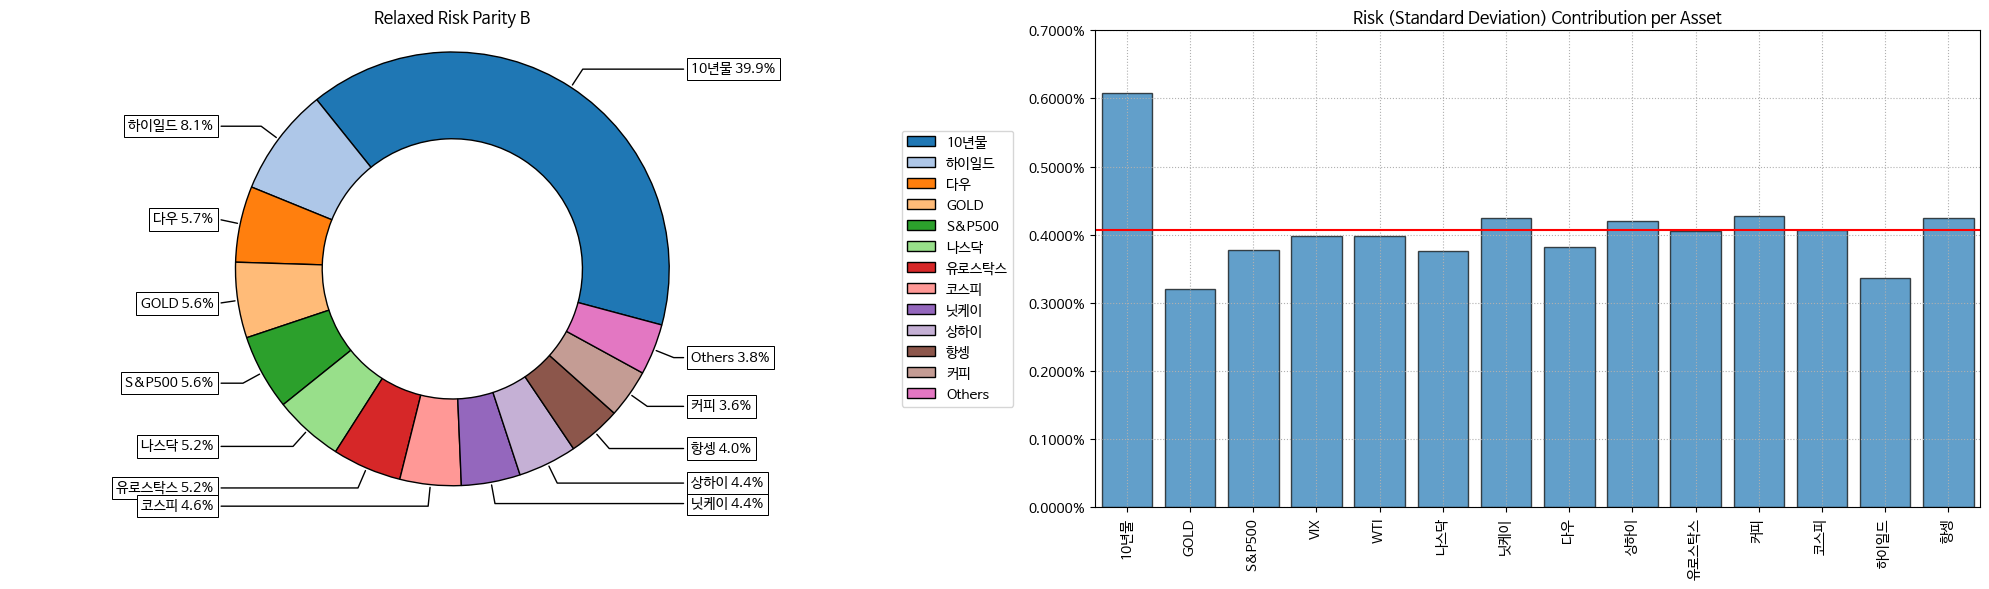

In [ ]:
version = 'B' # Could be A, B or C

w_rrp_b = port.rrp_optimization(model=model, version=version, l=l, b=b, hist=hist)

display(w_rrp_b.T)

# Plotting the composition of the portfolio and risk composition side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the composition of the portfolio
rp.plot_pie(w=w_rrp_b, title='Relaxed Risk Parity B', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[0])

# Plotting the risk composition of the portfolio
rp.plot_risk_con(w_rrp_b, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01, color="tab:blue", erc_line=True, height=6, width=10, ax=axs[1])

# Show plots
plt.tight_layout()
plt.show()

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
weights,0.373030,0.064805,0.051328,0.027690,0.010541,0.047233,0.047814,0.052051,0.047618,0.049354,0.038002,0.052572,0.093913,0.044050


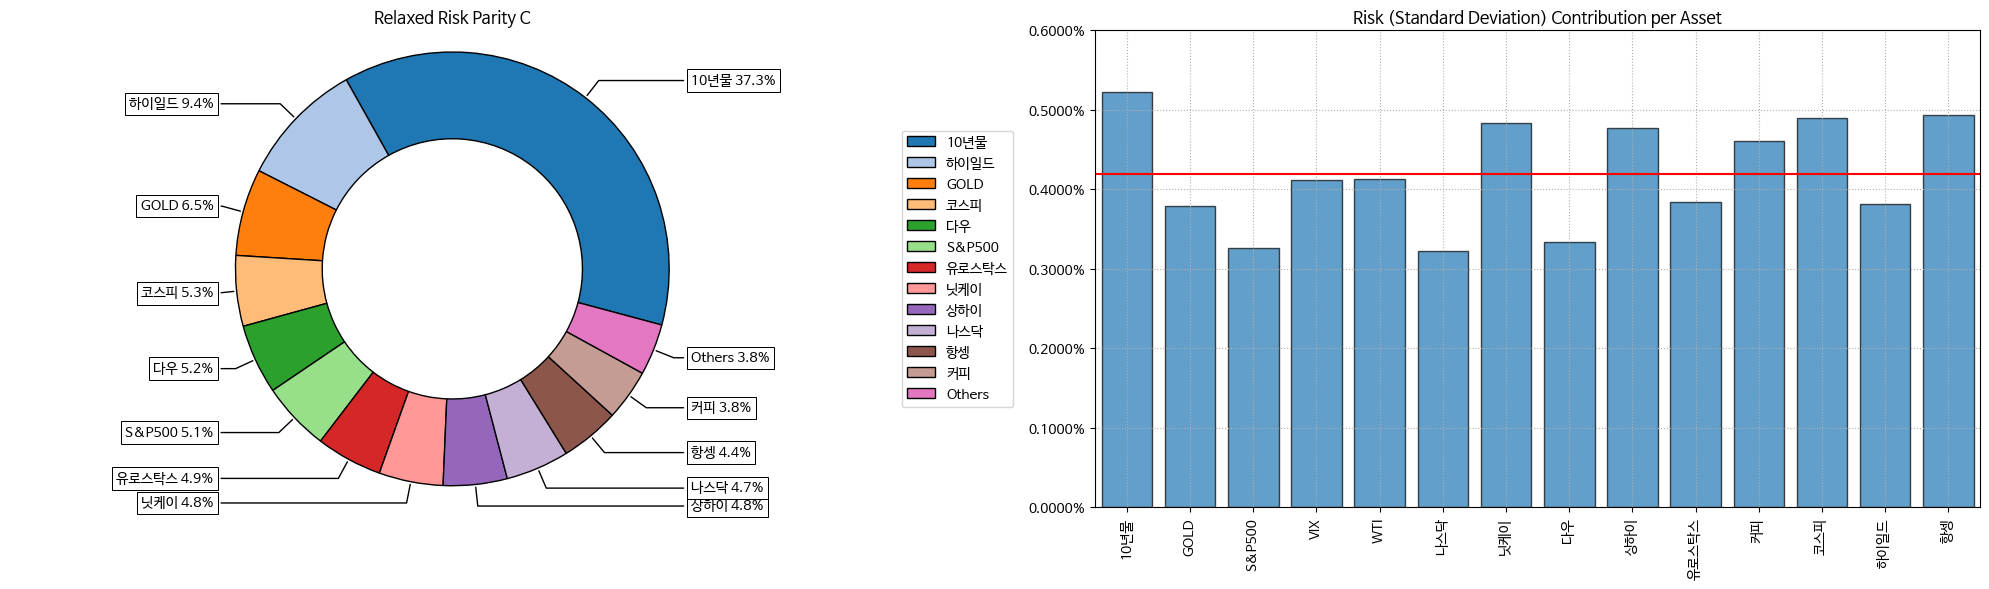

In [ ]:
version = 'C' # Could be A, B or C

w_rrp_c = port.rrp_optimization(model=model, version=version, l=l, b=b, hist=hist)

display(w_rrp_c.T)

# Plotting the composition of the portfolio and risk composition side by side
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plotting the composition of the portfolio
rp.plot_pie(w=w_rrp_c, title='Relaxed Risk Parity C', others=0.05, nrow=25, cmap="tab20", height=6, width=10, ax=axs[0])

# Plotting the risk composition of the portfolio
rp.plot_risk_con(w_rrp_c, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01, color="tab:blue", erc_line=True, height=6, width=10, ax=axs[1])

# Show plots
plt.tight_layout()
plt.show()

In [ ]:
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = 'Classic' # Could be Classic (historical) or FM (Factor Model)
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b=b, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms

In [ ]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,CDaR,UCI,EDaR
10년물,34.39%,28.55%,31.25%,26.25%,29.91%,31.50%,26.90%,10.10%,11.05%,12.57%
GOLD,7.21%,6.91%,7.59%,6.87%,7.52%,7.25%,7.35%,9.31%,12.47%,7.61%
S&P500,6.05%,7.34%,6.56%,8.27%,6.91%,6.77%,5.42%,9.20%,10.52%,8.27%
VIX,3.02%,3.23%,3.70%,3.63%,4.02%,4.01%,5.06%,7.58%,6.06%,9.02%
WTI,1.08%,2.08%,0.83%,1.69%,0.78%,1.01%,0.47%,1.26%,1.49%,1.38%
나스닥,5.64%,6.19%,6.09%,7.21%,6.59%,6.54%,5.59%,8.21%,8.49%,9.34%
닛케이,4.46%,4.06%,4.50%,4.34%,4.64%,4.44%,5.90%,13.98%,8.72%,12.17%
다우,6.01%,7.77%,6.53%,8.37%,6.76%,6.82%,4.93%,9.59%,11.35%,7.73%
상하이,4.50%,3.93%,4.44%,3.73%,4.48%,4.06%,6.26%,3.65%,3.02%,3.82%
유로스탁스,5.28%,5.92%,5.43%,5.95%,5.44%,5.15%,4.57%,4.67%,5.18%,4.75%


<Axes: >

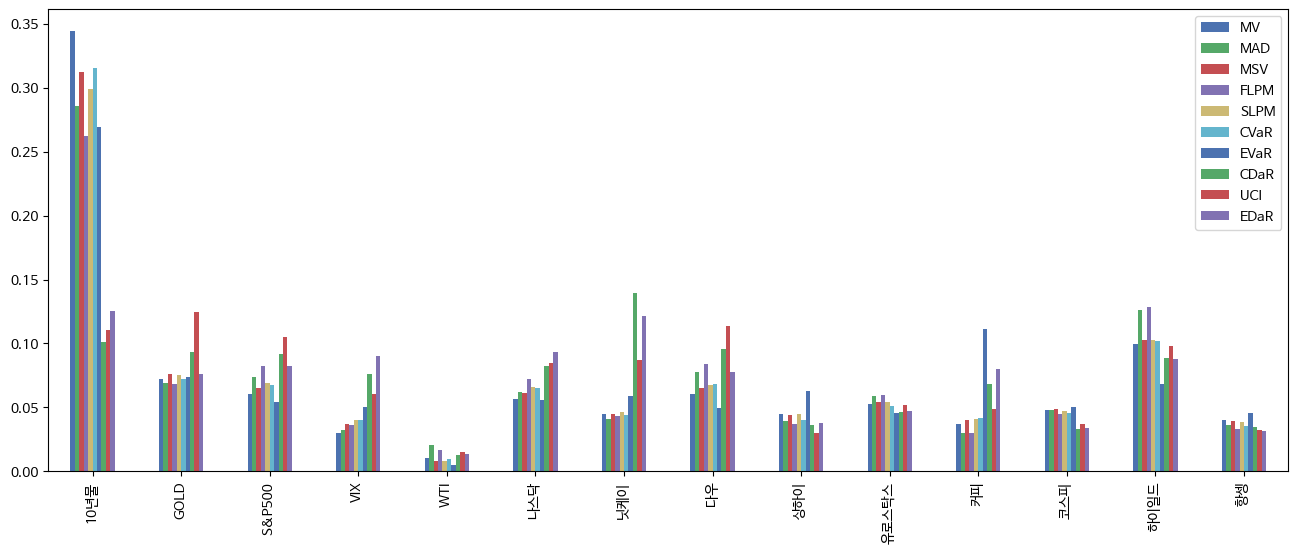

In [ ]:
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(16)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

---
# 4. 백테스트

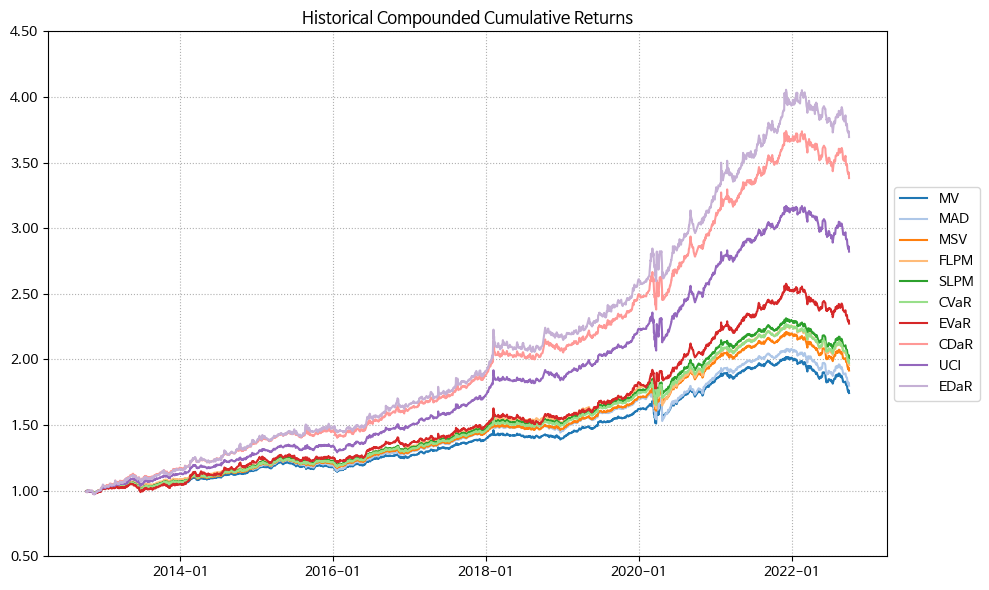

In [ ]:
ax = rp.plot_series(returns=Y,
                    w=w_s,
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

In [71]:
W = pd.read_csv("W.csv", index_col='RM')
W

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
RM,,,,,,,,,,,,,,
CDaR_,0.101010,0.093123,0.092003,0.075760,0.012647,0.082085,0.139846,0.095911,0.036473,0.046684,0.068463,0.032969,0.088703,0.034324
EDaR_,0.125655,0.076067,0.082725,0.090182,0.013782,0.093446,0.121709,0.077336,0.038211,0.047545,0.079901,0.033813,0.088124,0.031503
CVaR_,0.315042,0.072536,0.067744,0.040081,0.010065,0.065356,0.044420,0.068176,0.040572,0.051490,0.042097,0.045267,0.101855,0.035298
MV_,0.343946,0.072118,0.060474,0.030180,0.010767,0.056374,0.044584,0.060121,0.044956,0.052834,0.036690,0.047799,0.099231,0.039925
EQ_W,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
MV,0.000001,0.000002,0.131545,0.101483,0.000000,0.565235,0.157936,0.000004,0.000001,0.000000,0.043793,0.000000,0.000000,0.000000


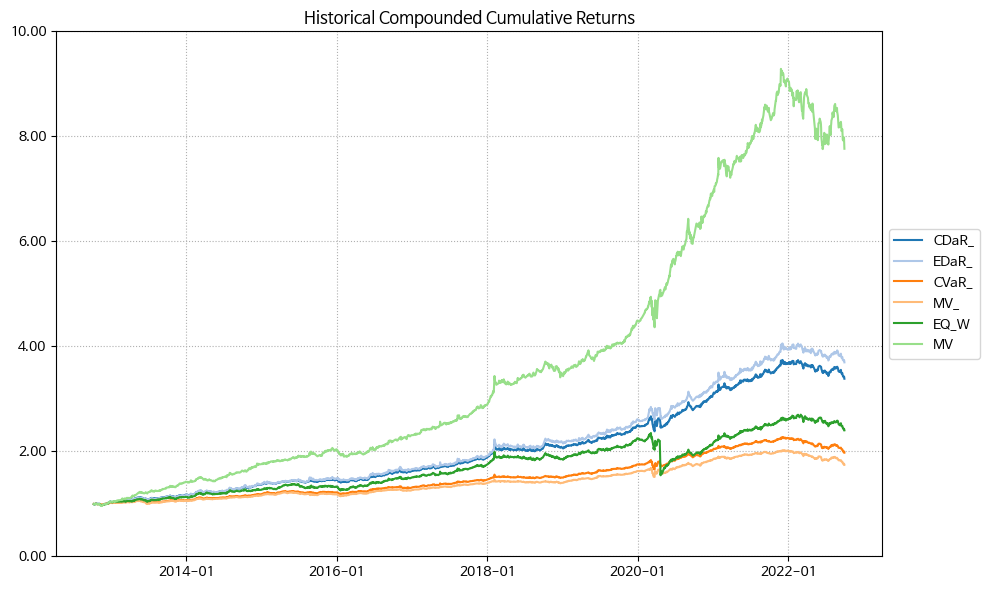

In [73]:
ax = rp.plot_series(returns=Y,
                    w=W.T,
                    cmap='tab20',
                    height=6,
                    width=10,
                    ax=None)

In [85]:
Y

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
Date,,,,,,,,,,,,,,
2012-10-10,0.001292,0.000113,-0.006188,-0.004887,-0.012339,-0.004320,-0.019768,-0.009542,0.002228,-0.006346,-0.011192,-0.017369,-0.002389,-0.000844
2012-10-11,0.000352,0.003176,0.000195,-0.042971,0.008986,-0.000777,-0.005753,-0.001392,-0.008054,0.012432,-0.016519,-0.009053,0.005443,0.003798
2012-10-12,0.000352,-0.006106,-0.002966,0.035279,-0.002281,-0.001738,-0.001481,0.000185,0.000981,-0.007233,0.005910,-0.001582,0.001733,0.006542
2012-10-15,0.000000,-0.012514,0.008078,-0.053903,-0.000109,0.006593,0.005133,0.007156,-0.002959,0.006492,-0.005257,-0.003961,0.004541,0.000559
2012-10-16,-0.003282,0.005011,0.010270,-0.003274,0.002613,0.012072,0.014383,0.009501,0.000050,0.025262,0.012123,0.010102,0.003658,0.002781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,-0.012334,-0.028429,-0.027395,0.179525,-0.081207,-0.023845,-0.026600,-0.027126,-0.018553,-0.024679,0.001118,-0.039383,-0.024364,-0.016135
2022-09-27,-0.004209,0.002094,-0.002120,0.010539,0.023335,0.002460,0.005309,-0.004300,0.013971,-0.004162,0.002458,0.001484,-0.002104,0.000290
2022-09-28,0.017754,0.020717,0.019672,-0.074233,0.046497,0.020512,-0.014974,0.018835,-0.015770,0.001998,0.019389,-0.024156,0.017855,-0.034122


In [86]:
W

,10년물,GOLD,S&P500,VIX,WTI,나스닥,닛케이,다우,상하이,유로스탁스,커피,코스피,하이일드,항셍
RM,,,,,,,,,,,,,,
CDaR_,0.101010,0.093123,0.092003,0.075760,0.012647,0.082085,0.139846,0.095911,0.036473,0.046684,0.068463,0.032969,0.088703,0.034324
EDaR_,0.125655,0.076067,0.082725,0.090182,0.013782,0.093446,0.121709,0.077336,0.038211,0.047545,0.079901,0.033813,0.088124,0.031503
CVaR_,0.315042,0.072536,0.067744,0.040081,0.010065,0.065356,0.044420,0.068176,0.040572,0.051490,0.042097,0.045267,0.101855,0.035298
MV_,0.343946,0.072118,0.060474,0.030180,0.010767,0.056374,0.044584,0.060121,0.044956,0.052834,0.036690,0.047799,0.099231,0.039925
EQ_W,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
MV,0.000001,0.000002,0.131545,0.101483,0.000000,0.565235,0.157936,0.000004,0.000001,0.000000,0.043793,0.000000,0.000000,0.000000


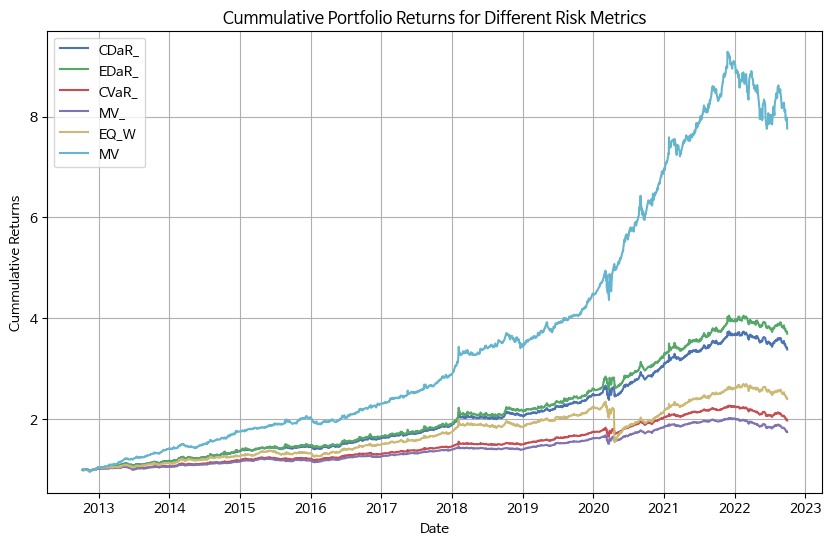

In [109]:
# 자산의 수익률을 로드합니다.
returns = pd.read_csv('Y.csv', index_col='Date', parse_dates=True)

# 비중을 로드합니다.
weights = pd.read_csv('W.csv', index_col='RM')

# 포트폴리오 수익률을 계산하는 함수입니다.
def calculate_portfolio_returns(weights, returns):
    portfolio_returns = returns.dot(weights.T)  # 각 리스크 메트릭에 대한 포트폴리오 수익률을 계산합니다.
    return portfolio_returns

# 포트폴리오 수익률을 계산합니다.
portfolio_returns = calculate_portfolio_returns(weights, returns)

# 누적 수익률을 계산합니다.
cumulative_returns = (1 + portfolio_returns).cumprod()

# 누적 수익률을 그래프로 그립니다.
plt.figure(figsize=(10,6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cummulative Portfolio Returns for Different Risk Metrics')
plt.xlabel('Date')
plt.ylabel('Cummulative Returns')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  14 of 14 completed


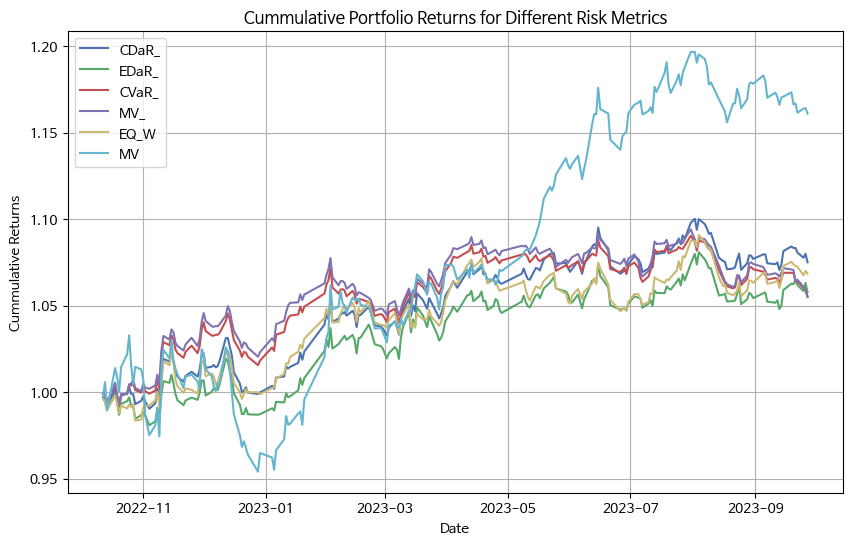

In [110]:
# Date range
start = '2022-10-05'
end = '2023-10-05'

asset = yf.download(ticker_labels['ticker'], start = start, end = end)
asset = asset.loc[:,('Adj Close', slice(None))]
asset = asset.rename(columns=new_dict)
asset.columns = asset.columns.droplevel(level=0)
asset = asset.sort_index(axis=1)
asset = asset.dropna()
Y = asset.pct_change().dropna()

# 자산의 수익률을 로드합니다.
returns = Y
# 비중을 로드합니다.
weights = pd.read_csv('W.csv', index_col='RM')

# 포트폴리오 수익률을 계산합니다.
portfolio_returns = calculate_portfolio_returns(weights, returns)

# 누적 수익률을 계산합니다.
cumulative_returns = (1 + portfolio_returns).cumprod()

# 누적 수익률을 그래프로 그립니다.
plt.figure(figsize=(10,6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cummulative Portfolio Returns for Different Risk Metrics')
plt.xlabel('Date')
plt.ylabel('Cummulative Returns')
plt.legend()
plt.grid(True)
plt.show()

---

## 30년간 Hist

In [135]:
# Date range
start = '1991-10-05'
end = '2021-10-05'

asset = yf.download(ticker_labels['ticker'], start = start, end = end)
asset = asset.loc[:,('Adj Close', slice(None))]
asset = asset.rename(columns=new_dict)
asset.columns = asset.columns.droplevel(level=0)
asset = asset.sort_index(axis=1)
asset = asset.dropna()
Y = asset.pct_change().dropna()

[*********************100%%**********************]  14 of 14 completed


## 일반적인 MVO

In [136]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

MV_W = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
MV_W.rename(columns={'weights': 'MV_W'}, inplace=True)
MV_W

,MV_W
10년물,0.299917
GOLD,0.075776
S&P500,0.000001
VIX,0.072634
WTI,0.000000
나스닥,0.430641
닛케이,0.032923
다우,0.000001
상하이,0.000007
유로스탁스,0.000000


In [138]:
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model = 'Classic' # Could be Classic (historical) or FM (Factor Model)
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
b = None # Risk contribution constraints vector

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'CVaR', 'EVaR', 'CDaR', 'EDaR']

w_s = pd.DataFrame([])

# 3분 정도 소요됨
for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b=b, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)

w_s.columns = rms
w_s

,MV,CVaR,EVaR,CDaR,EDaR
10년물,0.388422,0.380624,0.270988,0.355572,0.425607
GOLD,0.067969,0.065602,0.120224,0.056187,0.061249
S&P500,0.058170,0.060383,0.055128,0.053941,0.044118
VIX,0.034206,0.046126,0.067696,0.089049,0.083211
WTI,0.013433,0.012675,0.006849,0.013155,0.012474
나스닥,0.058995,0.063761,0.056808,0.111143,0.083902
닛케이,0.037827,0.034097,0.032501,0.042268,0.038962
다우,0.060929,0.062919,0.053859,0.053174,0.043825
상하이,0.042646,0.036925,0.056690,0.015693,0.016210
유로스탁스,0.045709,0.040960,0.047521,0.035227,0.030763


In [139]:
EQ_W = MV_W.copy()
EQ_W[:] = 1/14
EQ_W.rename(columns={'MV_W': 'EQ_W'}, inplace=True)
EQ_W

,EQ_W
10년물,0.071429
GOLD,0.071429
S&P500,0.071429
VIX,0.071429
WTI,0.071429
나스닥,0.071429
닛케이,0.071429
다우,0.071429
상하이,0.071429
유로스탁스,0.071429


In [140]:
# 데이터프레임 리스트
weights_list = [MV_W, w_s, EQ_W]

# 데이터프레임 합치기
combined_weights = pd.concat(weights_list, axis=1)

combined_weights

,MV_W,MV,CVaR,EVaR,CDaR,EDaR,EQ_W
10년물,0.299917,0.388422,0.380624,0.270988,0.355572,0.425607,0.071429
GOLD,0.075776,0.067969,0.065602,0.120224,0.056187,0.061249,0.071429
S&P500,0.000001,0.058170,0.060383,0.055128,0.053941,0.044118,0.071429
VIX,0.072634,0.034206,0.046126,0.067696,0.089049,0.083211,0.071429
WTI,0.000000,0.013433,0.012675,0.006849,0.013155,0.012474,0.071429
나스닥,0.430641,0.058995,0.063761,0.056808,0.111143,0.083902,0.071429
닛케이,0.032923,0.037827,0.034097,0.032501,0.042268,0.038962,0.071429
다우,0.000001,0.060929,0.062919,0.053859,0.053174,0.043825,0.071429
상하이,0.000007,0.042646,0.036925,0.056690,0.015693,0.016210,0.071429
유로스탁스,0.000000,0.045709,0.040960,0.047521,0.035227,0.030763,0.071429


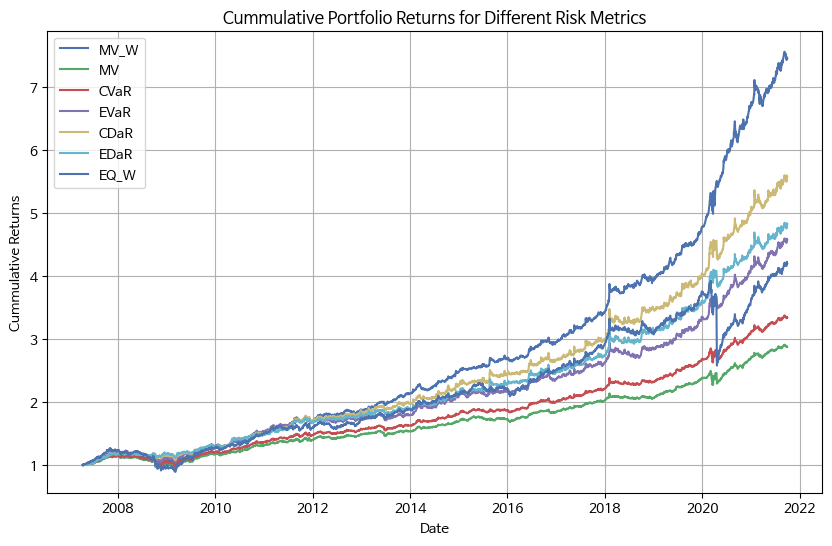

In [141]:
returns = Y

# 비중을 로드합니다.
weights = combined_weights.T

# 포트폴리오 수익률을 계산합니다.
portfolio_returns = calculate_portfolio_returns(weights, returns)

# 누적 수익률을 계산합니다.
cumulative_returns = (1 + portfolio_returns).cumprod()

# 누적 수익률을 그래프로 그립니다.
plt.figure(figsize=(10,6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cummulative Portfolio Returns for Different Risk Metrics')
plt.xlabel('Date')
plt.ylabel('Cummulative Returns')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%%**********************]  14 of 14 completed


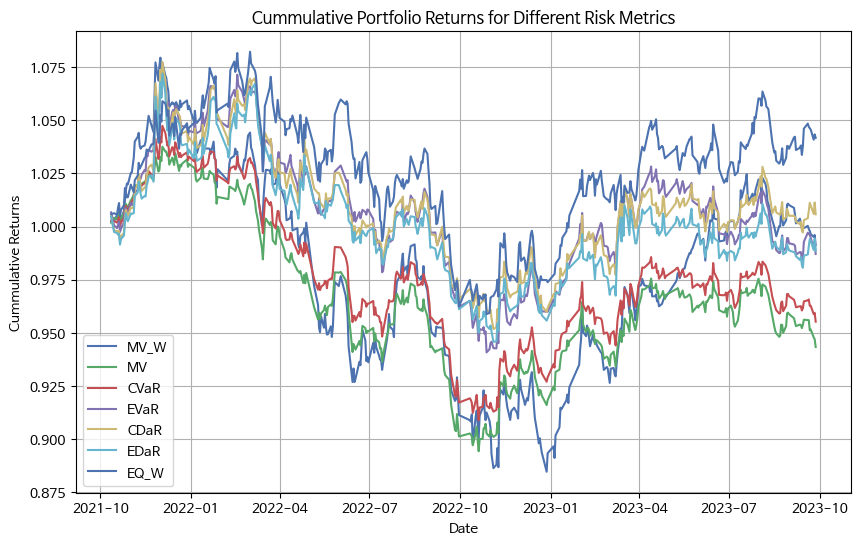

In [142]:
# Date range
start = '2021-10-06'
end = '2023-10-05'

asset = yf.download(ticker_labels['ticker'], start = start, end = end)
asset = asset.loc[:,('Adj Close', slice(None))]
asset = asset.rename(columns=new_dict)
asset.columns = asset.columns.droplevel(level=0)
asset = asset.sort_index(axis=1)
asset = asset.dropna()
backtest = asset.pct_change().dropna()

returns = backtest

# 비중을 로드합니다.
weights = combined_weights.T

# 포트폴리오 수익률을 계산합니다.
portfolio_returns = calculate_portfolio_returns(weights, returns)

# 누적 수익률을 계산합니다.
cumulative_returns = (1 + portfolio_returns).cumprod()

# 누적 수익률을 그래프로 그립니다.
plt.figure(figsize=(10,6))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=column)

plt.title('Cummulative Portfolio Returns for Different Risk Metrics')
plt.xlabel('Date')
plt.ylabel('Cummulative Returns')
plt.legend()
plt.grid(True)
plt.show()

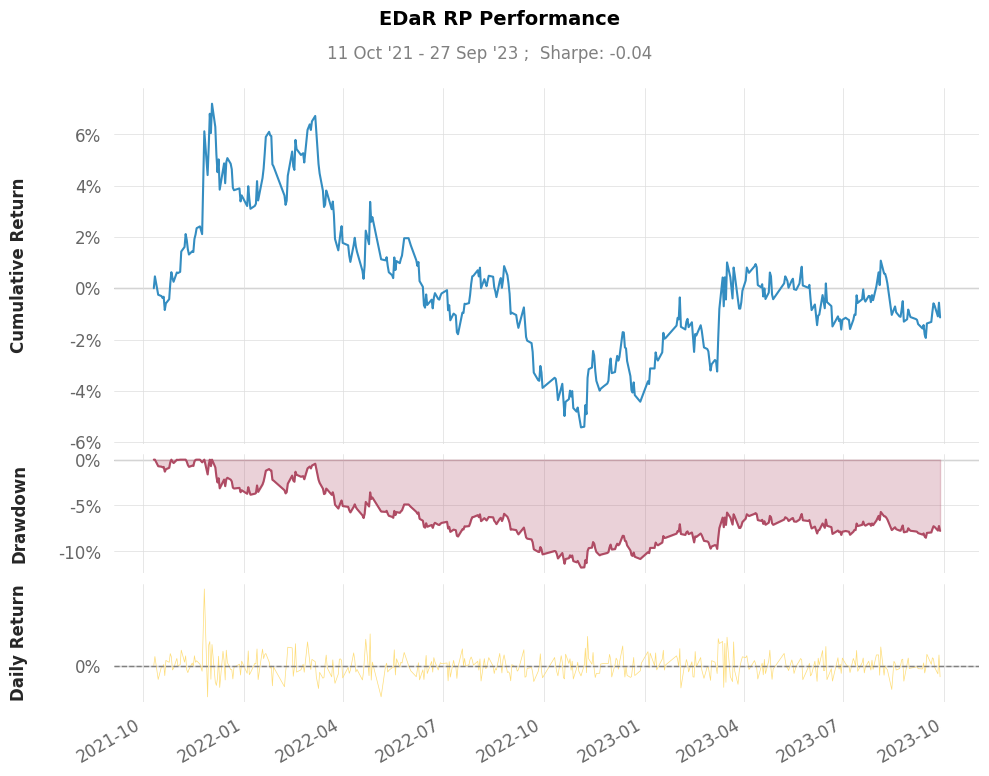

In [155]:
import quantstats as qs
# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# or using extend_pandas() :)
qs.plots.snapshot(portfolio_returns['EDaR'], title='EDaR RP Performance', show=True)

NameError: ignored

In [160]:
import os
qs.reports.html(portfolio_returns['EDaR'], "SPY", output=os.getpwd())

AttributeError: ignored